In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


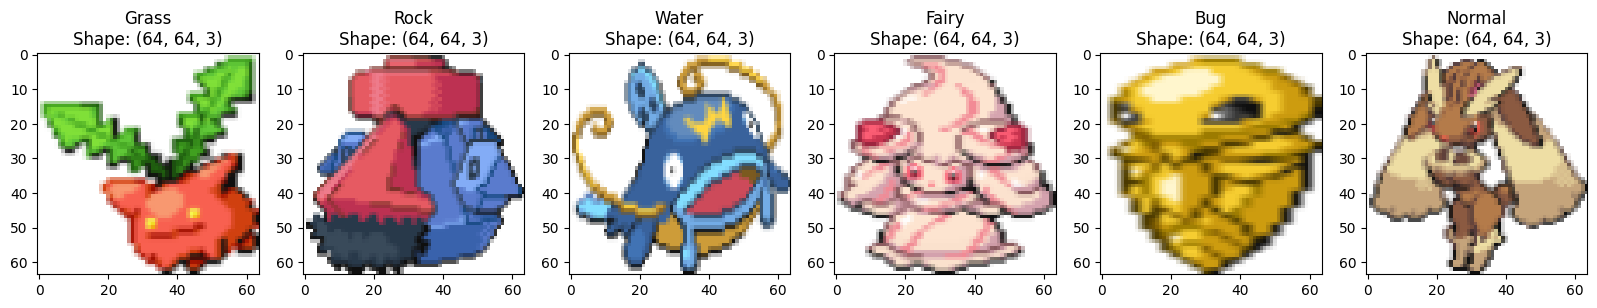

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1715117597.872501   80673 service.cc:145] XLA service 0x760ec0003c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715117597.872528   80673 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715117598.407618   80673 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715117599.665652   80787 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7020', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1715117599.806807   80793 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7020', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1715117599.851189   80800 asm_compiler.cc:369] ptxas war

  2/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 1.1377  

I0000 00:00:1715117609.305042   80673 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.9955
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.9824
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.9424
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.9270
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.9120
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.9074
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.9051
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.9039
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.9031
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.9014
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8966
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.9013
Epoch 13/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8966
Epoch 14/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8971
Epoch 15/100
127/127 ━━━━━━━━━━━━━━━━━━━

Sampling sprite: 1000it [00:54, 18.27it/s]                        


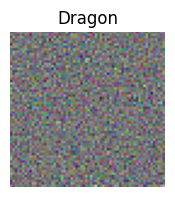

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - loss: 0.8958
Epoch 21/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8969
Epoch 22/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8961
Epoch 23/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8991
Epoch 24/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8917
Epoch 25/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8960
Epoch 26/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8944
Epoch 27/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8936
Epoch 28/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8894
Epoch 29/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8950
Epoch 30/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8947
Epoch 31/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8902
Epoch 32/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8903
Epoch 33/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8956
Epoch 34/100
127/127 ━━━━━━━━━━

Sampling sprite: 1000it [00:53, 18.86it/s]                        


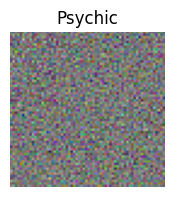

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 495ms/step - loss: 0.8898
Epoch 41/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8889
Epoch 42/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8969
Epoch 43/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8895
Epoch 44/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8879
Epoch 45/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8887
Epoch 46/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8918
Epoch 47/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8888
Epoch 48/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8889
Epoch 49/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8926
Epoch 50/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8935
Epoch 51/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8895
Epoch 52/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8912
Epoch 53/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8905
Epoch 54/100
127/127 ━━━━━━━━━━

Sampling sprite: 1000it [00:53, 18.64it/s]                        


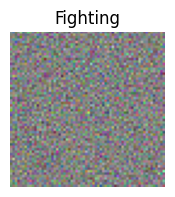

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 500ms/step - loss: 0.8908
Epoch 61/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8879
Epoch 62/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8876
Epoch 63/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8884
Epoch 64/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8899
Epoch 65/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8902
Epoch 66/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8922
Epoch 67/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8914
Epoch 68/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8884
Epoch 69/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8902
Epoch 70/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8914
Epoch 71/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8895
Epoch 72/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8887
Epoch 73/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8881
Epoch 74/100
127/127 ━━━━━━━━━━

Sampling sprite: 1000it [00:54, 18.24it/s]                        


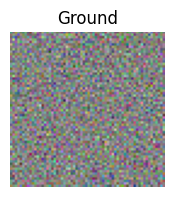

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - loss: 0.8861
Epoch 81/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8884
Epoch 82/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8914
Epoch 83/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8856
Epoch 84/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8915
Epoch 85/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8908
Epoch 86/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8857
Epoch 87/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8880
Epoch 88/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8843
Epoch 89/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8870
Epoch 90/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8874
Epoch 91/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8877
Epoch 92/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8881
Epoch 93/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8906
Epoch 94/100
127/127 ━━━━━━━━━━

Sampling sprite: 1000it [00:53, 18.65it/s]                        


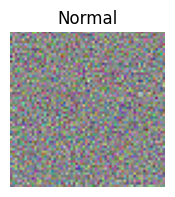

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 499ms/step - loss: 0.8861


In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.8857
Epoch 2/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8904
Epoch 3/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8885
Epoch 4/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8904
Epoch 5/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8879
Epoch 6/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8875
Epoch 7/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8893
Epoch 8/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8855
Epoch 9/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8865
Epoch 10/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8861
Epoch 11/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8856
Epoch 12/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8893
Epoch 13/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8844
Epoch 14/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8882
Epoch 15/500
127/127 ━━━━━━━━

Sampling sprite: 1000it [00:52, 18.99it/s]                        


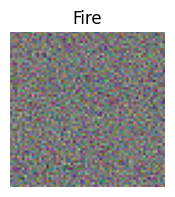

127/127 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - loss: 0.8886
Epoch 21/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8833
Epoch 22/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8876
Epoch 23/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8879
Epoch 24/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.8849
Epoch 25/500
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.8890
Epoch 26/500
 37/127 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.8915

In [8]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

[BACK TO TOP](#top)